In [ ]:
import pandas as pd
import numpy as np, os
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Dropout, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre processing

In [ ]:
folder_path = f"/content/drive/MyDrive/AI-project/128"

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_128.csv')]

# Initialize an empty DataFrame to concatenate all data
all_data = pd.DataFrame()
all_data_list = []
list_128 = []
# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    list_128.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

In [ ]:
folder_path = f"/content/drive/MyDrive/AI-project/250"

# List all files in the folder
file_names = [file for file in os.listdir(folder_path) if file.endswith('_250.csv')]

list_250 = []

# Loop through each file and concatenate the data
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    data = pd.read_csv(file_path)
    all_data_list.append(data)
    list_250.append(data)
    all_data = pd.concat([all_data, data], ignore_index=True)

# Now 'all_data_list' contains a list of all data from all CSV files

# Signal Segmentation

In [ ]:
 = 200window_size

In [ ]:
# Segment each patient's signal
#Voglio window size di 5 secondi
# --> 128 samples/s *5s = 640
half_window = window_size // 2

column_names = ['id', 'segment_values', 'label']
df_segments_patients_all = pd.DataFrame(columns=column_names)

id = 0

for patient_data in list_128:
    patient_signal = patient_data['value'].values

    for i in range(0, len(patient_signal)):
        if(patient_data['IsPeak'].values[i] == True):
            if(not(i-half_window <0) and not(i+half_window > len(patient_signal)-1) ):
                segment = patient_signal[i-half_window:i+half_window]

                #Add segment to list only if it is a 'proper window' --> i-window, i+ window garanteed
                df_segments_patient_temp = pd.DataFrame({'id': id,
                                        'segment_values': [segment],
                                        'label': patient_data['PeakNature'].values[i]})
                df_segments_patients_all = pd.concat([df_segments_patients_all, df_segments_patient_temp], ignore_index=True)

    id = id + 1

In [ ]:
for patient_data in list_250:
    patient_signal = patient_data['value'].values

    for i in range(0, len(patient_signal)):
        if(patient_data['IsPeak'].values[i] == True):
            if(not(i-(half_window*2) <0) and not(i+(half_window*2) > len(patient_signal)-1) ):
                segment = patient_signal[i-(half_window*2):i+(half_window*2) : 2]

                #Add segment to list only if it is a 'proper window' --> i-window, i+ window garanteed
                df_segments_patient_temp = pd.DataFrame({'id': id,
                                        'segment_values': [segment],
                                        'label': patient_data['PeakNature'].values[i]})
                df_segments_patients_all = pd.concat([df_segments_patients_all, df_segments_patient_temp], ignore_index=True)

    id = id + 1

In [ ]:
%store df_segments_patients_all

Stored 'df_segments_patients_all' (DataFrame)


# For kernel restarting

In [ ]:

import pandas as pd
import numpy as np, os
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Dropout, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf

window_size = 100

%store -r df_segments_patients_all


# Train / Val / Test split

In [ ]:
df_segments_patients_all

,id,segment_values,label
0,0,"[-0.8033273470740767, -0.8149286909426211, -0....",N
1,0,"[-0.6996423492429004, -0.7525355246396694, -0....",N
2,0,"[-0.9486917475027408, -0.9923837820854492, -1....",N
3,0,"[0.0764916719532077, 0.0125841409351811, -0.04...",S
4,0,"[-0.6048863489604988, -0.6482966832142557, -0....",N
...,...,...,...
174878,104,"[-4.850159121439207, -3.874373577847762, -2.86...",N
174879,104,"[8.614188480807233, 7.967094035250176, 7.10134...",N
174880,104,"[-1.1104398054454914, -1.1675897682392098, -1....",N
174881,104,"[-1.094942867015577, -1.1373028821267126, -1.1...",N


In [ ]:
np.random.seed(20)

In [ ]:
num_patients = df_segments_patients_all['id'].nunique()

train_indices = np.random.choice(range(num_patients), size=int(num_patients * 0.7), replace=False)
validation_indices = np.random.choice(list(set(range(num_patients)) - set(train_indices)), size=int(num_patients * 0.15), replace=False)
test_indices = list(set(range(num_patients)) - set(train_indices) - set(validation_indices))


In [ ]:
label_mapping = {"N": 0, "V": 1, "S": 2}

In [ ]:
train_df = df_segments_patients_all[df_segments_patients_all['id'].isin(train_indices)].drop(['id'], axis=1)
# Split dataframe into features and labels
X_train = train_df.drop(['label'], axis=1).values
y_train = train_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_train_list = train_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_train_df = pd.DataFrame(X_train_list)
X_train_np = X_train_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_train, columns=['label'])
one_hot_encoded_array_train = one_hot_encoded_df.values

Y_train = [label_mapping[value] for value in y_train]
Y_train_categorical = tf.keras.utils.to_categorical(Y_train, num_classes=3)

In [ ]:
nN = np.count_nonzero(y_train == 'N')
nS = np.count_nonzero(y_train == 'S')
nV = np.count_nonzero(y_train == 'V')

print("Perc N : ")
print(nN/(nN + nS + nV))
print("Perc S : ")
print(nS/(nN + nS + nV))
print("Perc V : ")
print(nV/(nN + nS + nV))

Perc N : 
0.9278587425209747
Perc S : 
0.03481298258515225
Perc V : 
0.03732827489387305


In [ ]:
validation_df = df_segments_patients_all[df_segments_patients_all['id'].isin(validation_indices)].drop(['id'], axis=1)
# Split dataframe into features and labels
X_validation = validation_df.drop(['label'], axis=1).values
y_validation = validation_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_validation_list = validation_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_validation_df = pd.DataFrame(X_validation_list)
X_val_np = X_validation_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_validation, columns=['label'])
one_hot_encoded_array_validation = one_hot_encoded_df.values

Y_validation = [label_mapping[value] for value in y_validation]
Y_validation_categorical = tf.keras.utils.to_categorical(Y_validation, num_classes=3)

In [ ]:
test_df = df_segments_patients_all[df_segments_patients_all['id'].isin(test_indices)].drop(['id'], axis=1)
# Split dataframe into features and labels
X_test = test_df.drop(['label'], axis=1).values

y_test = test_df['label']

# Convert segments to a numpy array and reshape for CNN input
X_test_list = test_df['segment_values'].apply(lambda x: x.tolist()).tolist()
X_test_df = pd.DataFrame(X_test_list)
X_test_np = X_test_df.to_numpy()

# One-hot encoding
one_hot_encoded_df = pd.get_dummies(y_test, columns=['label'])
one_hot_encoded_array_test = one_hot_encoded_df.values

Y_test = [label_mapping[value] for value in y_test]
Y_test_categorical = tf.keras.utils.to_categorical(Y_test, num_classes=3)

# Model

In [ ]:
# Define a simple 1D CNN model
# Define the CNN architecture
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(BatchNormalization())

model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(1024))

model.add(Dropout(0.5))

model.add(Activation('relu'))

model.add(Dense(3, activation='softmax'))


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will stop
    verbose=1,
    restore_best_weights=True  # Restore the best model weights when training stops
)

In [ ]:
nN = np.count_nonzero(y_train == 'N')
nS = np.count_nonzero(y_train == 'S')
nV = np.count_nonzero(y_train == 'V')

class_sum = nN+nV+nS
wN = round(1-(nN/class_sum),2)
wS = round(1-(nS/class_sum),2)
wV = round(1-(nV/class_sum),2)

class_weights_fed = {0: wN, 1: wS, 2: wV}

In [ ]:
class_weights_fed

{0: 0.07, 1: 0.97, 2: 0.96}

In [ ]:
model.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['Accuracy', 'Precision', 'Recall' ])

In [ ]:
# Train the model on the training set
history = model.fit(X_train_np,
                    one_hot_encoded_array_train,
                    epochs=20,
                    callbacks=[early_stopping],
                    class_weight = class_weights_fed,
                    validation_data=(X_val_np, one_hot_encoded_array_validation))

Epoch 1/20
3740/3740 [==============================] - 45s 11ms/step - loss: 0.1141 - Accuracy: 0.8539 - precision: 0.9036 - recall: 0.7819 - val_loss: 0.4597 - val_Accuracy: 0.8489 - val_precision: 0.9044 - val_recall: 0.7490
Epoch 2/20
3740/3740 [==============================] - 38s 10ms/step - loss: 0.0902 - Accuracy: 0.8808 - precision: 0.9254 - recall: 0.7980 - val_loss: 0.4478 - val_Accuracy: 0.8870 - val_precision: 0.8985 - val_recall: 0.8796
Epoch 3/20
3740/3740 [==============================] - 43s 12ms/step - loss: 0.0835 - Accuracy: 0.8988 - precision: 0.9386 - recall: 0.8040 - val_loss: 0.3939 - val_Accuracy: 0.8708 - val_precision: 0.9094 - val_recall: 0.7618
Epoch 4/20
3740/3740 [==============================] - 40s 11ms/step - loss: 0.0830 - Accuracy: 0.8944 - precision: 0.9339 - recall: 0.8152 - val_loss: 0.4142 - val_Accuracy: 0.8672 - val_precision: 0.9217 - val_recall: 0.7390
Epoch 5/20
3740/3740 [==============================] - 39s 10ms/step - loss: 0.0787 - A

# Evaluate

In [ ]:
def model_evaluation(y_predi, model_name_pred):
    predicted_class = np.argmax(y_predi, axis=-1)
    test_classes = np.argmax(one_hot_encoded_array_test, axis=-1)
    cm = confusion_matrix(test_classes, predicted_class)
    classes_name = ['N', 'S', 'V']

    #Normalized cm

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=list(classes_name), yticklabels=list(classes_name), cmap="Greens", annot=True,
                fmt='.2f')
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.title(model_name_pred)
    plt.show()

984/984 [==============================] - 3s 3ms/step


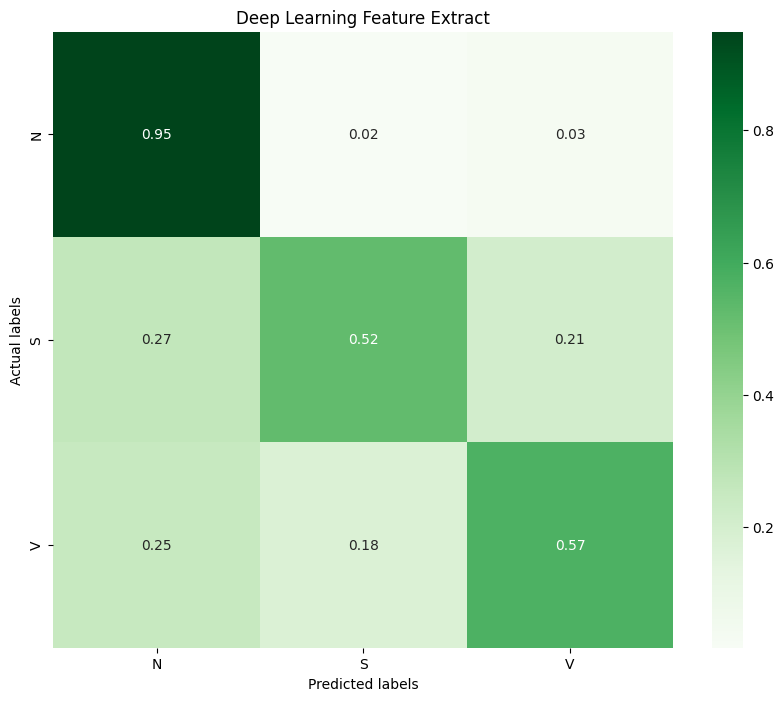

In [ ]:
y_predi = model.predict(X_test_np)

model_evaluation(y_predi, "Deep Learning Feature Extract")